# Homework - Attacks and Defenses in Federated Learning

> ✨
> 
> `🥝Name` 
> - Chenrui Fan
> 
> `🍉Student ID` 
> - 23-125-818
> 
> `🍑Github` 
> - [Link](https://github.com/Sosekie/DDLS_Assignment/blob/main/lab/Chenrui_hw-attacks.ipynb)
> 
> ✨

In this assignment, we will further explore the impact of various attacks and corresponding defenses within the context of federated learning. 

# Instructions

Submit your assignment as a Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.

## Question 1: Influence of Non-I.I.D. Data in Attacks and Defenses (4 points)

Using the template code from [lab-attacks.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-attacks.ipynb), experiment with how non-i.i.d. data distributions influence the performance of attacks and defenses. Utilize the `AttackerGradientReversion` for the attack. Keep all hyperparameters the same as those in the template code, except modify the data distribution among the clients to be non-i.i.d.

### Scoring:

- _(1 point)_ Generate test accuracy for 10 rounds, both when there is no defense and when the defenses are `krum`, `multi_krum`, and `majority_sign`. 
- _(1 point)_ Compile the results of these runs into one plot to visually compare the influence of each defense mechanism under non-i.i.d. conditions.
- _(2 points)_ Discuss the differences (if any) between the results in i.i.d. and non-i.i.d. settings for each defense mechanism. 

In [1]:
from base import *
if torch.cuda.is_available():
    gpu_type = torch.cuda.get_device_name(0)
    print("GPU Type:", gpu_type)

cuda
GPU Type: NVIDIA GeForce RTX 4090


### - _(1 point)_ Generate test accuracy for 10 rounds, both when there is no defense and when the defenses are `krum`, `multi_krum`, and `majority_sign`. 

Modify the data distribution among the clients to be non-i.i.d.

In [2]:
sample_split_iid = split(100, True, 42)
sample_split_non_iid = split(100, False, 42)
sample_splits = [sample_split_iid, sample_split_non_iid]
result = []

In [3]:
class GradWeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values
        self.generator.manual_seed(seed)
        initial_weights = [param.clone() for param in self.model.parameters()]
        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)
        gradients = [initial_weight - final_weight for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]
        return [gradient.detach().cpu().clone() for gradient in gradients]
    

class FedAvgGradServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            GradWeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]
    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data
            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())
        return run_result

Utilize the `AttackerGradientReversion` for the attack.

In [4]:
# malicious clients
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)
        
        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]

        return reversed_gradients

#### Case 1: There is no defense

#### Case 2: The defenses are `krum`

In [5]:
def krum(clients_updates, n=20, m=4):
    # Number of neighboring updates to consider
    n_neighbors = n - m - 2
    scores = []

    # Calculate the score for each update
    for i in range(len(clients_updates)):
        distances = []
        for j in range(len(clients_updates)):
            if i != j:
                # Compute squared l2 distance between updates
                distance = sum((param_i - param_j).pow(2).sum()
                               for param_i, param_j in zip(clients_updates[i][1], clients_updates[j][1]))
                distances.append(distance)

        # Get the n_neighbors smallest distances
        nearest_distances = sorted(distances)[:n_neighbors]
        # Sum of these distances is the score of this client's update
        scores.append(sum(nearest_distances))

    # Select the index with the smallest score
    selected_index = scores.index(min(scores))
    return [selected_index]
    
class FedAvgServerDefense(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, defense=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)
        
        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.
            
            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            if self.defense_method:
                selected_indices = self.defense_method(client_updates)
            else:
                selected_indices = range(len(client_updates))  # Use all updates if no defense is specified
            print(f'The following indices are selected in the training {np.sort(indices_chosen_clients[selected_indices])}')
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients[selected_indices])
            chosen_adjusted_weights = [
                [self.client_sample_counts[indices_chosen_clients[ind]] / chosen_sum_nr_samples * tens for tens in client_updates[ind][1]]
                for ind in selected_indices
            ]
            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]
            
            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient
            
            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data

            
            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

#### Case 3: The defenses are `multi_krum`

In [6]:
def multi_krum(clients_updates, k=14, n=20, m=5):
    selected_indices = []
    remaining_updates = clients_updates[:]

    for i in range(k):
        # Apply Krum to the remaining updates and get the index of the best gradient
        selected_index = krum(remaining_updates,n-i,m)[0]
        
        # Map selected index from remaining_updates back to the original clients_updates
        original_index = clients_updates.index(remaining_updates[selected_index])
        selected_indices.append(original_index)
        
        # Remove the selected update from remaining_updates
        remaining_updates.pop(selected_index)

    return selected_indices

#### Case 4: The defenses are `majority_sign`

In [7]:
class FedAvgServerDefenseCoordinate(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, defense=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)
        
        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.
            
            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            
            if self.defense_method:
                averaged_gradients = self.defense_method(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]
            
            
            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient
            
            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data

            
            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [8]:
def majority_sign_filter(all_updates):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.
    
    # Step 1: Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))
    
    # Step 2: Calculate sign and count for determining majority
    all_signs = [torch.sign(torch.stack(parameter_group, dim=0)) for parameter_group in parameter_wise_updates]
    
    # Step 3: Determine the majority sign for each parameter coordinate
    majority_signs = [torch.sign(torch.sum(signs, dim=0)) for signs in all_signs]
    
    # Step 4: Filter out gradients whose signs don't match the majority
    filtered_updates = []
    for idx, parameter_group in enumerate(parameter_wise_updates):
        majority_sign = majority_signs[idx]
        zeroed_gradients = []
        
        for gradient in parameter_group:
            gradient_signs = torch.sign(gradient)
            # Zero out gradients where the sign does not match the majority
            gradient[gradient_signs != majority_sign] = 0
            zeroed_gradients.append(gradient)
        
        # Step 5: Calculate the average of the filtered gradients
        filtered_average = torch.mean(torch.stack(zeroed_gradients), dim=0)
        filtered_updates.append(filtered_average*20)
    
    return filtered_updates

### - _(1 point)_ Compile the results of these runs into one plot to visually compare the influence of each defense mechanism under non-i.i.d. conditions.

### - _(2 points)_ Discuss the differences (if any) between the results in i.i.d. and non-i.i.d. settings for each defense mechanism. 

> All three methods perform well in the iid case, but poorly in the non-iid case.
> 
> Specifically analyzing the results, whether in the iid or non-iid case, the results when there is no defense mechanism are the worst, indicating that the defense mechanism is necessary.
> 
> In the iid case, the performance of the three methods is very close; in the non-iid case multi_krum and majority_sign perform a > little bit better than krum, probably because krum only looks for one clustering center.
> 
> This is because in the iid case, the distribution of the data on all clients is the same, and the distribution of the gradient > computed by the model is also similar. At this time, the poisonous gradient will be far away from this average distribution, and > it will be easily filtered out.
> 
> But in the non-iid case, the distribution of the gradient calculated by the model is not the same. At this time it is difficult to distinguish between normal and poisonous gradients because it is hard for us to know the center of the clusters. Therefore all three methods are not very useful under non-iid.

## Question 2: Implementing Bulyan Defense (5 points)

[Bulyan defense](https://arxiv.org/abs/1802.07927) combines aspects of `multi-krum` and `trimmed-mean` to protect against sophisticated attacks in federated environments. In this question, you will implement Bulyan by modifying and combining the existing code in the [lab-attacks.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-attacks.ipynb).

### Scoring:
- _(1 point)_ Modify the server-side code to integrate a two-step defense process where:
  1. A client-wise defense like `multi-krum` filters out suspicious gradients based on their distance metrics.
  2. A coordinate-wise defense like `trimmed-mean` calculates the mean across the remaining gradients after trimming the extremes.
  
- _(1 point)_ Successfully integrate these two defense mechanisms [`multi-krum`, `trimmed-mean`] to implement the Bulyan.
- _(3 points)_ Evaluate the performance of your implemented Bulyan defense against three types of attacks: `AttackerGradientReversion`, `AttackerPartGradientReversion`, and `AttackerBackdoor`. Vary the defense hyperparameters to make your defense defend against these attacks while keeping the data distribution i.i.d. and the attacker's hyperparameters constant as per the template. Document the performance of your defense strategy against these attacks in your notebook.

### - _(1 point)_ Modify the server-side code to integrate a two-step defense process where:
  1. A client-wise defense like `multi-krum` filters out suspicious gradients based on their distance metrics.
  2. A coordinate-wise defense like `trimmed-mean` calculates the mean across the remaining gradients after trimming the extremes.
### - _(1 point)_ Successfully integrate these two defense mechanisms [`multi-krum`, `trimmed-mean`] to implement the Bulyan.

The difference between these two methods in terms of code implementation is that the multi-krum method selects the updates and returns the index of the updates that can be trusted, while the trimmed-mean method calculates the average of the updates in a certain dimension directly after removing the ones that are either too small or too large, and returns the gradient that is calculated and then magnify the gradient by a factor of 20.

If we want to integrate them together, my idea is that we can first use the multi-krum method to select a batch of trustworthy updates corresponding to the index, and then apply the trimmed-mean method to these updates to calculate the average gradient.

Here, k=14, beta=0.2, n_attackers = int(20*beta). So we'll have 6 gradients to calcute the mean gradient.

In [9]:
def multi_krum(clients_updates, k=14, n=20, m=5):
    selected_indices = []
    remaining_updates = clients_updates[:]

    for i in range(k):
        # Apply Krum to the remaining updates and get the index of the best gradient
        selected_index = krum(remaining_updates,n-i,m)[0]
        
        # Map selected index from remaining_updates back to the original clients_updates
        original_index = clients_updates.index(remaining_updates[selected_index])
        selected_indices.append(original_index)
        
        # Remove the selected update from remaining_updates
        remaining_updates.pop(selected_index)
    # print('selected_indices: ', len(selected_indices))

    return selected_indices

def tr_mean(all_updates, beta=0.2):
    # 'n_attackers' is the number of top and bottom values to exclude from the mean calculation.
    
    # Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))
    n_attackers = int(20*beta)
    trimmed_mean_gradients = []
    for parameter_group in parameter_wise_updates:
        # Stack gradients to create a new dimension corresponding to clients
        stacked_updates = torch.stack(parameter_group, dim=0)
        
        # Sort updates along the client dimension
        sorted_updates = torch.sort(stacked_updates, dim=0)[0]
        # Compute mean excluding the top and bottom 'n_attackers' updates
        if n_attackers > 0:
            trimmed_updates = sorted_updates[n_attackers:-n_attackers]
        else:
            trimmed_updates = sorted_updates
        # print('sorted_updates: ', len(sorted_updates))
        # print('trimmed_updates: ', len(trimmed_updates))
            
        mean_gradient = torch.mean(trimmed_updates, dim=0)
        trimmed_mean_gradients.append(mean_gradient*20)
    
    return trimmed_mean_gradients

In [10]:
class FedAvgServerDefenseBulyan(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, defense_1=None, defense_2=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.multi_krum = defense_1
        self.tr_mean = defense_2

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)
        
        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.
            
            # Collect client updates
            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            
            # Apply multi_krum or use all updates
            if self.multi_krum:
                selected_indices = self.multi_krum(client_updates)
            else:
                selected_indices = range(len(client_updates))  # Use all updates if no defense is specified
            print(f'The following indices are selected in the training {np.sort(indices_chosen_clients[selected_indices])}')
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients[selected_indices])
            chosen_adjusted_weights = [
                [self.client_sample_counts[indices_chosen_clients[ind]] / chosen_sum_nr_samples * tens for tens in client_updates[ind][1]]
                for ind in selected_indices
            ]
            
            # Aggregation logic for tr_mean
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.tr_mean:
                averaged_gradients = self.tr_mean(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient
            
            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

### - _(3 points)_ Evaluate the performance of your implemented Bulyan defense against three types of attacks: `AttackerGradientReversion`, `AttackerPartGradientReversion`, and `AttackerBackdoor`. Vary the defense hyperparameters to make your defense defend against these attacks while keeping the data distribution i.i.d. and the attacker's hyperparameters constant as per the template. Document the performance of your defense strategy against these attacks in your notebook.

AttackerPartGradientReversion

In [11]:
class AttackerPartGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Set random seed for reproducibility
        torch.manual_seed(seed)

        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Flatten the gradients and calculate 10% of the total number of gradient elements
        all_gradients = torch.cat([g.flatten() for g in honest_gradients])
        num_to_manipulate = int(all_gradients.numel())

        # Determine the threshold of parameters to modify
        param_threshold = num_to_manipulate*0.00001  # Set this to your desired threshold

        # Select the first k layers until the cumulative number of parameters exceeds the threshold
        cumulative_params = 0
        selected_gradients = []
        for gradient in honest_gradients:
            #print(gradient.numel())
            cumulative_params += gradient.numel()
            selected_gradients.append(gradient)
            if cumulative_params >= param_threshold:
                break

        # Multiply the selected gradients by -1000
        for gradient in selected_gradients:
            gradient *= -1000

        return honest_gradients  # Return the modified gradients

AttackerBackdoor

In [12]:
import random

# a new data class that help us to process batch
@dataclass
class Batch:
    batch_id: int
    inputs: torch.Tensor
    labels: torch.Tensor

    def __post_init__(self):
        self.batch_size = self.inputs.shape[0]

    def to(self, device):
        inputs = self.inputs.to(device)
        labels = self.labels.to(device)
        return Batch(self.batch_id, inputs, labels)

    def clone(self):
        inputs = self.inputs.clone()
        labels = self.labels.clone()
        return Batch(self.batch_id, inputs, labels)


    def clip(self, batch_size):
        if batch_size is None:
            return self

        inputs = self.inputs[:batch_size]
        labels = self.labels[:batch_size]

        return Batch(self.batch_id, inputs, labels)

class Synthesizer:
    def __init__(self, poisoning_proportion):
        self.poisoning_proportion = poisoning_proportion

    def make_backdoor_batch(self, batch: Batch, test=False, attack=True) -> Batch:
        if not attack:
            return batch

        if test:
            attack_portion = batch.batch_size
        else:
            attack_portion = round(
                batch.batch_size * self.poisoning_proportion)

        backdoored_batch = batch.clone()
        self.apply_backdoor(backdoored_batch, attack_portion)
        return backdoored_batch

    def apply_backdoor(self, batch, attack_portion):
        """
        Modifies only a portion of the batch (represents batch poisoning).

        :param batch:
        :return:
        """
        self.synthesize_inputs(batch=batch, attack_portion=attack_portion)
        self.synthesize_labels(batch=batch, attack_portion=attack_portion)

        return

    def synthesize_inputs(self, batch, attack_portion=None):
        raise NotImplemented

    def synthesize_labels(self, batch, attack_portion=None):
        raise NotImplemented

class PatternSynthesizer(Synthesizer):
    pattern_tensor: torch.Tensor = torch.tensor([
        [1., 0., 1.],
        [-10., 1., -10.],
        [-10., -10., 0.],
        [-10., 1., -10.],
        [1., 0., 1.]
    ])
    "Just some random 2D pattern."

    x_top = 3
    "X coordinate to put the backdoor into."
    y_top = 23
    "Y coordinate to put the backdoor into."

    mask_value = -10
    "A tensor coordinate with this value won't be applied to the image."

    resize_scale = (5, 10)
    "If the pattern is dynamically placed, resize the pattern."

    mask: torch.Tensor = None
    "A mask used to combine backdoor pattern with the original image."

    pattern: torch.Tensor = None
    "A tensor of the `input.shape` filled with `mask_value` except backdoor."

    def __init__(self, poisoning_proportion):
        super().__init__(poisoning_proportion)
        self.input_shape = (1, 28, 28)
        self.backdoor_label = 0
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        self.make_pattern(self.pattern_tensor, self.x_top, self.y_top)


    def make_pattern(self, pattern_tensor, x_top, y_top):
        # put pattern into the image
        full_image = torch.zeros(self.input_shape)
        full_image.fill_(self.mask_value)
        # full image has a pixel value of -10
        x_bot = x_top + pattern_tensor.shape[0]
        y_bot = y_top + pattern_tensor.shape[1]

        if x_bot >= self.input_shape[1] or \
                y_bot >= self.input_shape[2]:
            raise ValueError(f'Position of backdoor outside image limits:'
                             f'image: {self.input_shape}, but backdoor'
                             f'ends at ({x_bot}, {y_bot})')

        full_image[:, x_top:x_bot, y_top:y_bot] = pattern_tensor
        # full image has a pixel value of -10 except for the backdoor (pattern_tensor) size: 5 * 3
        self.mask = 1 * (full_image != self.mask_value).to(device) # (0, 1)
        # mask is a tensor of 0 and 1, 0 for -10 and 1 for other values
        self.pattern = self.normalize(full_image).to(device) # )(-52.5678, 2.7537)


    def synthesize_inputs(self, batch, attack_portion=None):
        pattern, mask = self.get_pattern()
        # mask value (0, 1); value 0, keep the original image; value 1, replace with pattern
        batch.inputs[:attack_portion] = (1 - mask) * \
                                        batch.inputs[:attack_portion] + \
                                        mask * pattern

        return

    def synthesize_labels(self, batch, attack_portion=None):
        batch.labels[:attack_portion].fill_(self.backdoor_label)
        return

    def get_pattern(self):
        return self.pattern, self.mask

In [13]:
poisoning_proportion = 0.5 
synthesizer = PatternSynthesizer(poisoning_proportion=poisoning_proportion)

In [14]:
class AttackerBackdoor(GradWeightClient):
    def train_epoch(self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
        model.train()
        for batch_idx, (inputs, labels) in enumerate(loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(batch, test=False, attack=True)
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)
        
        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]
        
        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)
        
        # Calculate gradients: final_weights - initial_weights
        gradients = [5*(initial_weight - final_weight) for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]
        
        return [gradient.detach().cpu().clone() for gradient in gradients]

#### Evaluate part

In [15]:
sample_split = split(100, True, 42)

## Question 3: Implementing SparseFed Defense (7 points)

In this exercise, you will implement the [SparseFed Defense](https://arxiv.org/abs/2112.06274). SparseFed Defense involves two main steps for each participating device during the training process:
1. **Clipping the gradient:** Each device clips its gradient to reduce the impact of potentially malicious updates.
2. **Aggregating top-k updates:** During the aggregation phase, only the gradients with the highest magnitudes (top-k) are considered. This method is designed to minimize the risk of model poisoning by excluding anomalous gradient contributions from potentially compromised devices.

### Scoring:
- _(2 points)_ Implement a simplified version of SparseFed based on the clipping code provided in the template notebook. Unlike the original algorithm which includes momentum, you only need to implement the clipping step and the sparsification step. However, ensure that only the top-k coordinates in the aggregated gradients are selected based on their magnitudes. For example, if the aggregated gradient is `[3, -1, -1, -3]`, selecting the top-2 by magnitude should result in `[3, 0, 0, -3]`.

- _(3 points)_ Evaluate the performance of your implemented SparseFed defense against two types of attacks: `AttackerGradientReversion` and `AttackerBackdoor`. Adjust the values of the defense hyperparameter k to optimize defense effectiveness. Ensure the data distribution remains i.i.d., and the attacker's hyperparameters are unchanged from the template. Document and compare the performance of SparseFed to the simple clipping defense across these attack scenarios. Suggested values for k include percentages of the total parameters, such as 20%, 50%, and 80%.

- _(2 points)_ Analyze and discuss the results to determine if SparseFed provided any improvements. Explain why the sparsefication either succeeded or failed in enhancing the model's robustness against the specified attacks. Include this analysis in your notebook.


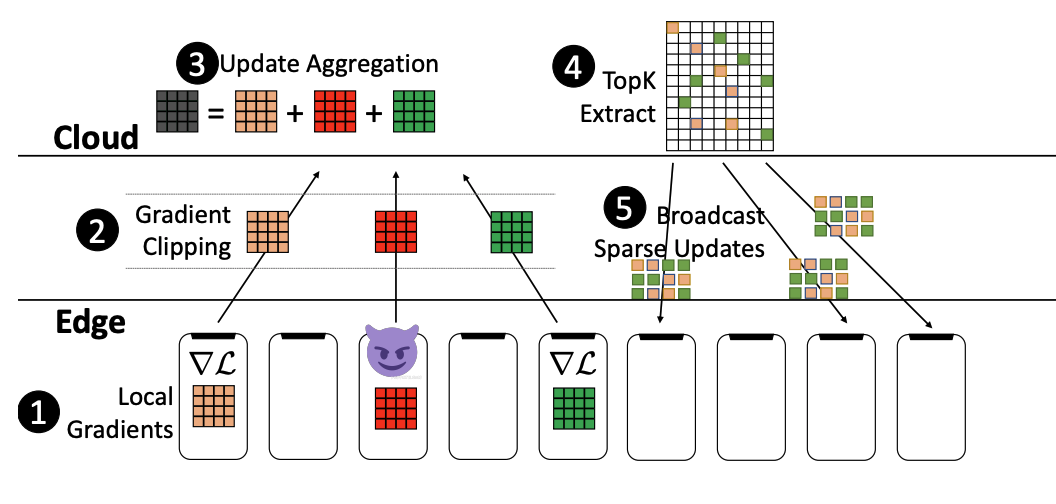


### - _(2 points)_ Implement a simplified version of SparseFed based on the clipping code provided in the template notebook. Unlike the original algorithm which includes momentum, you only need to implement the clipping step and the sparsification step. However, ensure that only the top-k coordinates in the aggregated gradients are selected based on their magnitudes. For example, if the aggregated gradient is `[3, -1, -1, -3]`, selecting the top-2 by magnitude should result in `[3, 0, 0, -3]`.

In [16]:
def SparseFed(all_updates, clip_norm_ratio=1.0, noise_std_dev=0.01, top_k_percentage = 0.5):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.
    
    # Step 1: Calculate the norm of each client's update
    norms = [torch.norm(torch.stack([torch.norm(p) for p in client_update])) for client_update in all_updates]
    average_norm = sum(norms) / len(norms) * clip_norm_ratio
    
    # Step 2: Clip each client's update
    clipped_updates = []
    for client_update in all_updates:
        clipped_update = []
        client_norm = torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        clip_scale = min(1, average_norm / (client_norm + 1e-6))  # Avoid division by zero
        for gradient in client_update:
            clipped_gradient = gradient * clip_scale
            clipped_update.append(clipped_gradient)
        clipped_updates.append(clipped_update)
    
    # Step 3: Compute the average of these modified gradients
    parameter_wise_updates = list(zip(*clipped_updates))
    averaged_gradients = [torch.mean(torch.stack(parameter_group), dim=0)*20 for parameter_group in parameter_wise_updates]
    
    # Step 4: Select only top-k updates based on magnitude
    top_k_averaged_gradients = []
    flat_averaged_gradients = torch.cat([t.view(-1) for t in averaged_gradients])
    k = int(top_k_percentage * flat_averaged_gradients.numel())
    # print(flat_averaged_gradients.numel(), k)
    if k == 0:
        return [torch.zeros_like(t) for t in averaged_gradients]
    _, indices = torch.topk(flat_averaged_gradients.abs(), k=k, largest=True, sorted=False)
    mask = torch.zeros_like(flat_averaged_gradients)
    mask[indices] = 1
    index = 0
    for gradient in averaged_gradients:
        numel = gradient.numel()
        tensor_mask = mask[index:index + numel].reshape(gradient.shape)
        # print(tensor_mask.size())
        top_k_averaged_gradients.append(gradient * tensor_mask)
        index += numel

    return averaged_gradients

### - _(3 points)_ Evaluate the performance of your implemented SparseFed defense against two types of attacks: `AttackerGradientReversion` and `AttackerBackdoor`. Adjust the values of the defense hyperparameter k to optimize defense effectiveness. Ensure the data distribution remains i.i.d., and the attacker's hyperparameters are unchanged from the template. Document and compare the performance of SparseFed to the simple clipping defense across these attack scenarios. Suggested values for k include percentages of the total parameters, such as 20%, 50%, and 80%.

Simple Clipping

In [17]:
def clipping(all_updates, clip_norm_ratio=1.0, noise_std_dev=0.01):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.
    
    # Step 1: Calculate the norm of each client's update
    norms = [torch.norm(torch.stack([torch.norm(p) for p in client_update])) for client_update in all_updates]
    average_norm = sum(norms) / len(norms) * clip_norm_ratio
    
    # Step 2: Clip each client's update
    clipped_updates = []
    for client_update in all_updates:
        clipped_update = []
        client_norm = torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        clip_scale = min(1, average_norm / (client_norm + 1e-6))  # Avoid division by zero
        
        for gradient in client_update:
            clipped_gradient = gradient * clip_scale
            
            clipped_update.append(clipped_gradient)
        
        clipped_updates.append(clipped_update)
    
    # Step 4: Compute the average of these modified gradients
    parameter_wise_updates = list(zip(*clipped_updates))
    averaged_gradients = [torch.mean(torch.stack(parameter_group), dim=0)*20 for parameter_group in parameter_wise_updates]
    
    return averaged_gradients

In [18]:
class FedAvgServerDefenseCoordinate_SparseFed(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, defense=None, top_k_percentage=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense
        self.top_k_percentage = top_k_percentage
    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.
            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.defense_method == SparseFed:
                averaged_gradients = self.defense_method(chosen_adjusted_weights, top_k_percentage = self.top_k_percentage)
            elif self.defense_method == clipping:
                averaged_gradients = self.defense_method(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data
            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [29]:
class FedAvgServerDefense_MultiKrum_Sparse(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, top_k_percentage=0.2):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.multi_krum = multi_krum
        self.SparseFed = SparseFed
        self.top_k_percentage = top_k_percentage

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)
        
        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.
            
            # Collect client updates
            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            
            # Apply multi_krum or use all updates
            if self.multi_krum:
                selected_indices = self.multi_krum(client_updates)
            else:
                selected_indices = range(len(client_updates))  # Use all updates if no defense is specified
            # print(f'The following indices are selected in the training {np.sort(indices_chosen_clients[selected_indices])}')
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients[selected_indices])
            chosen_adjusted_weights = [
                [self.client_sample_counts[indices_chosen_clients[ind]] / chosen_sum_nr_samples * tens for tens in client_updates[ind][1]]
                for ind in selected_indices
            ]
            
            # Aggregation logic for tr_mean
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.SparseFed:
                averaged_gradients = self.SparseFed(chosen_adjusted_weights, top_k_percentage = self.top_k_percentage)
            else:
                averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient
            
            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [30]:
sample_split = split(100, True, 42)
result_clipping = []
attacks = [AttackerGradientReversion, AttackerPartGradientReversion, AttackerBackdoor]
top_k_percentage = [0.2, 0.5, 0.8]

In [31]:
for index in range(len(top_k_percentage)):
    for attack in attacks:
        print(f'Attack: {attack.__name__} - Top K Percentage: {top_k_percentage[index]}')
        fedavg_server = FedAvgServerDefense_MultiKrum_Sparse(0.02, 200, sample_split, 0.2, 2, 42, top_k_percentage=top_k_percentage[index])
        clients = fedavg_server.clients
        num_malicious = int(0.20 * len(clients))
        malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
        for idx in malicious_indices:
            client_data = clients[idx].loader_train.dataset
            lr = clients[idx].optimizer.param_groups[0]['lr']
            batch_size = clients[idx].loader_train.batch_size
            nr_epochs = clients[idx].nr_epochs
            clients[idx] = attack(client_data, lr, batch_size, nr_epochs)
        result_fedavg_clipping = fedavg_server.run(10)
        fedavg_df_clipping = result_fedavg_clipping.as_df()
        result_clipping.append(fedavg_df_clipping)
        print(result_clipping[-1]['Test accuracy'])
fedavg_df_clipping

Top K Percentage: 0.2


0    42.45
1    62.49
2    71.08
3    77.06
4    79.26
5    83.92
6    84.11
7    86.23
8    87.69
9    88.00
Name: Test accuracy, dtype: float64
Top K Percentage: 0.2


0    32.54
1    45.26
2    62.37
3    72.88
4    64.69
5    73.50
6    33.72
7    65.45
8    31.07
9    32.71
Name: Test accuracy, dtype: float64
Top K Percentage: 0.2


0    13.35
1    47.41
2    65.85
3    77.64
4    79.18
5    83.08
6    86.15
7    85.86
8    88.21
9    88.92
Name: Test accuracy, dtype: float64
Top K Percentage: 0.5


0    14.70
1    53.75
2    68.09
3    75.75
4    78.57
5    82.28
6    84.32
7    85.94
8    87.43
9    88.21
Name: Test accuracy, dtype: float64
Top K Percentage: 0.5


0    25.94
1    57.33
2    10.14
3    42.67
4    61.26
5    66.46
6    71.93
7     9.80
8    11.51
9    25.85
Name: Test accuracy, dtype: float64
Top K Percentage: 0.5


0    37.32
1    63.08
2    62.91
3    78.41
4    80.42
5    82.96
6    86.20
7    86.72
8    86.90
9    88.62
Name: Test accuracy, dtype: float64
Top K Percentage: 0.8


0    32.21
1    47.40
2    68.18
3    76.00
4    77.74
5    82.55
6    83.59
7    85.96
8    87.63
9    88.38
Name: Test accuracy, dtype: float64
Top K Percentage: 0.8


0    35.44
1    66.05
2    71.67
3    79.00
4    81.18
5    83.73
6    85.44
7    86.78
8    35.50
9    85.46
Name: Test accuracy, dtype: float64
Top K Percentage: 0.8


0    13.65
1    50.15
2    20.62
3    77.43
4    78.74
5    83.08
6    85.34
7    86.54
8    87.63
9    88.74
Name: Test accuracy, dtype: float64


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,0.1,40,13.65
1,2,FedAvg,100,0.2,200,2,0.02,42,0.2,80,50.15
2,3,FedAvg,100,0.2,200,2,0.02,42,0.3,120,20.62
3,4,FedAvg,100,0.2,200,2,0.02,42,0.4,160,77.43
4,5,FedAvg,100,0.2,200,2,0.02,42,0.5,200,78.74
5,6,FedAvg,100,0.2,200,2,0.02,42,0.6,240,83.08
6,7,FedAvg,100,0.2,200,2,0.02,42,0.7,280,85.34
7,8,FedAvg,100,0.2,200,2,0.02,42,0.9,320,86.54
8,9,FedAvg,100,0.2,200,2,0.02,42,0.9,360,87.63
9,10,FedAvg,100,0.2,200,2,0.02,42,1.1,400,88.74


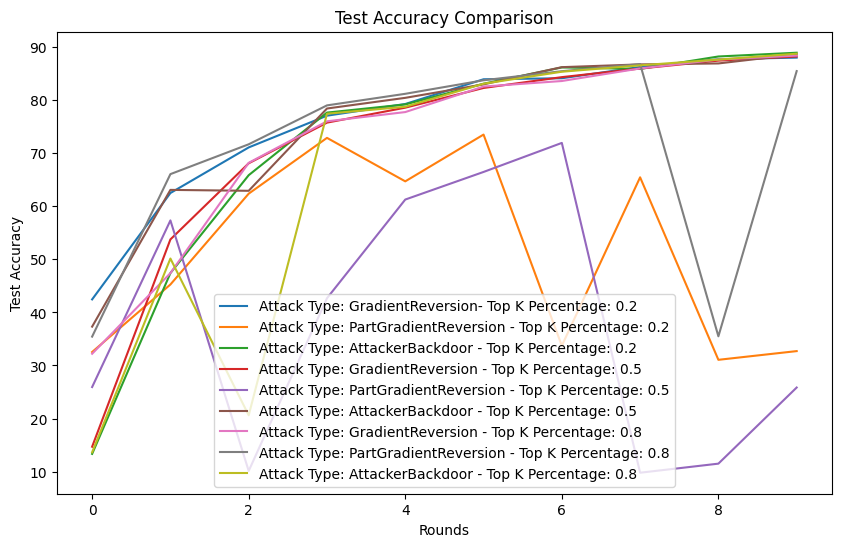

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

test_accuracies = pd.DataFrame({
    'Attack Type: GradientReversion- Top K Percentage: 0.2': result_clipping[0]['Test accuracy'],
    'Attack Type: PartGradientReversion - Top K Percentage: 0.2': result_clipping[1]['Test accuracy'],
    'Attack Type: AttackerBackdoor - Top K Percentage: 0.2': result_clipping[2]['Test accuracy'],

    'Attack Type: GradientReversion - Top K Percentage: 0.5': result_clipping[3]['Test accuracy'],
    'Attack Type: PartGradientReversion - Top K Percentage: 0.5': result_clipping[4]['Test accuracy'],
    'Attack Type: AttackerBackdoor - Top K Percentage: 0.5': result_clipping[5]['Test accuracy'],

    'Attack Type: GradientReversion - Top K Percentage: 0.8': result_clipping[6]['Test accuracy'],
    'Attack Type: PartGradientReversion - Top K Percentage: 0.8': result_clipping[7]['Test accuracy'],
    'Attack Type: AttackerBackdoor - Top K Percentage: 0.8': result_clipping[8]['Test accuracy'],
})

plt.figure(figsize=(10, 6))
for column in test_accuracies.columns:
    plt.plot(test_accuracies[column], label=column)

plt.title('Test Accuracy Comparison')
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

### - _(2 points)_ Analyze and discuss the results to determine if SparseFed provided any improvements. Explain why the sparsefication either succeeded or failed in enhancing the model's robustness against the specified attacks. Include this analysis in your notebook.

It can be seen that both clipping and SparseFed experiments are not very good, suggesting that using norm for scaling may not be a good approach. I analyzed the effect of L2-norm on gradient (attached in the appendix) and came to the following conclusions:

- Fixing the number of poisonous gradients, clipping can reduce the poisonous gradients when there are not so many gradients, but it is not very useful;

- When the gradients become very large, scale = 1, it is no longer possible to limit the poisonous gradients.

SparseFed works a little better than clipping. I analyzed it and found that in fact the process of choosing the Top-K gradient doesn't actually filter out toxic gradients, as I said earlier. The purpose of choosing Top-K gradient is to select a batch of larger gradients, which may be benign or toxic gradients (I think if it is a partly gradient reverse attack, it will definitely select toxic gradients). If they are averaged, the benign gradients can “hold back” the toxic gradients, but if the top-k is not selected (i.e., the smaller gradients are kept), the smaller gradients will weaken the larger benign gradients.

I've drawn a diagram to make this easier to understand, please see in demo.png

https://github.com/Sosekie/DDLS_Assignment/blob/main/lab/demo.png

### For any questions regarding this assignment, send an email to c.zhu-2@tudelft.nl

Appendice.

Experiments on the usefulness of norm.

In [ ]:
import math

num_ones = 9999
large_value = 10
norm = math.sqrt(num_ones * 10**2 + 1*large_value**2)
norm = 1000.0 # average norm

large_value = 10*1000
norm = math.sqrt(num_ones * 10**2 + 1*large_value**2)
norm = 10049.87 # then the scale is near 1/10

num_ones = 100000
reverse = 1
norm = math.sqrt(num_ones * (2*reverse)**2)
norm = 632.45

num_ones = 100000
reverse = -5
norm = math.sqrt(num_ones * (2*reverse)**2)
norm = 3162.27 # means krum will work

# if partly change, even only one gradient
num_ones = 99999
large_value = 2*(-1000)
norm = math.sqrt(num_ones * 2**2 + 1*large_value**2)
norm = 2097.61 > 632.45 # means krum will work too

# scale num_ones
num_ones = 999999
large_value = 2*(-1000)
norm = math.sqrt(num_ones * 2**2 + 1*large_value**2)
norm = 2828.42 # average norm=2000.0, still have some distance

# continue scale num_ones
num_ones = 9999999
large_value = 2*(-1000)
norm = math.sqrt(num_ones * 2**2 + 1*large_value**2)
norm = 6633.24 # average norm=6324.55, 

num_ones = 9999000
large_value = 2*(-1000)
norm = math.sqrt(num_ones * 2**2 + 1000*large_value**2)
norm = 63560.96
